In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import string
from tqdm import tqdm
from collections import Counter
from itertools import tee

In [3]:
from IPython.display import display

In [4]:
import numpy as np
from scipy import stats
from scipy.sparse import hstack as sparse_hstack
import pandas as pd

In [5]:
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
#Statistic methods
def tconfint(sample, alpha=0.05):
    '''Confidence interval based on Student t distribution.'''
    mean = np.mean(sample)
    S = np.std(sample, ddof=1)
    n = len(sample)

    t = stats.t.ppf(1 - alpha / 2, n - 1)
    left_boundary = mean - t * S / np.sqrt(n)
    right_boundary = mean + t * S / np.sqrt(n)

    return left_boundary, right_boundary

In [9]:
def tconfint_diff(sample1, sample2, alpha=0.05):
    '''Confidence interval based on Student t distribution for
    the difference in means of two samples.'''
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    s1 = np.std(sample1, ddof=1)
    s2 = np.std(sample2, ddof=1)
    n1 = len(sample1)
    n2 = len(sample2)

    sem1 = np.var(sample1) / (n1 - 1)
    sem2 = np.var(sample2) / (n2 - 1)
    semsum = sem1 + sem2
    z1 = (sem1 / semsum) ** 2 / (n1 - 1)
    z2 = (sem2 / semsum) ** 2 / (n2 - 1)
    dof = 1 / (z1 + z2)

    t = stats.t.ppf(1 - alpha / 2, dof)
    left_boundary = (mean1 - mean2) - t * np.sqrt((s1 ** 2) / n1 + (s2 ** 2) / n2)
    right_boundary = (mean1 - mean2) + t * np.sqrt((s1 ** 2) / n1 + (s2 ** 2) / n2)

    return left_boundary, right_boundary

In [10]:
def bootstrap_statint(sample, stat=np.mean, n_samples=5000, alpha=0.05):
    '''Statistical interval for a `stat` of a `sample` calculation
    using bootstrap sampling mechanism. `stat` is a numpy function
    like np.mean, np.std, np.median, np.max, np.min, etc.'''
    indices = np.random.randint(0, len(sample), (n_samples, len(sample)))
    samples = sample[indices]

    stat_scores = stat(samples, axis=1)
    boundaries = np.percentile(stat_scores, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

In [11]:
def bootstrap_statint_diff(sample1, sample2, stat=np.mean, n_samples=5000, alpha=0.05):
    '''Statistical interval for a difference in `stat` of two samples
    calculation using bootstrap sampling mechanism. `stat` is a numpy
    function like np.mean, np.std, np.median, np.max, np.min, etc.'''
    indices1 = np.random.randint(0, len(sample1), (n_samples, len(sample1)))
    indices2 = np.random.randint(0, len(sample2), (n_samples, len(sample2)))
    samples1 = sample1[indices1]
    samples2 = sample2[indices2]

    stat_scores1 = stat(samples1, axis=1)
    stat_scores2 = stat(samples2, axis=1)
    stat_scores_diff = stat_scores1 - stat_scores2
    boundaries = np.percentile(stat_scores_diff, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

In [12]:
def proportion_confint(sample, alpha=0.05):
    '''Wilson\'s сonfidence interval for a proportion.'''
    p = np.mean(sample)
    n = len(sample)

    z = stats.norm.ppf(1 - alpha / 2)
    left_boundary = 1 / (1 + z ** 2 / n) * (p + z ** 2 / (2 * n) \
                                            - z * np.sqrt(p * (1 - p) / n + z ** 2 / (4 * n ** 2)))
    right_boundary = 1 / (1 + z ** 2 / n) * (p + z ** 2 / (2 * n) \
                                             + z * np.sqrt(p * (1 - p) / n + z ** 2 / (4 * n ** 2)))

    return left_boundary, right_boundary

In [13]:
def proportions_diff_confint_ind(sample1, sample2, alpha=0.05):
    '''Confidence interval for the difference of two independent proportions.'''
    z = stats.norm.ppf(1 - alpha / 2)
    p1 = np.mean(sample1)
    p2 = np.mean(sample2)
    n1 = len(sample1)
    n2 = len(sample2)

    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)

    return left_boundary, right_boundary

In [14]:
def permutation_test_ind(sample1, sample2, max_permutations=None, alternative='two-sided'):
    '''Permutation test for two independent samples.'''
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError('Alternative not recognized, should be \'two-sided\', \'less\' or \'greater\'.')

    t_stat = np.mean(sample1) - np.mean(sample2)

    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)

    if max_permutations:
        index = list(range(n))
        indices = set([tuple(index)])
        for _ in range(max_permutations - 1):
            np.random.shuffle(index)
            indices.add(tuple(index))

        indices = [(index[:n1], index[n1:]) for index in indices]
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]

    zero_distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
                  for i in indices]

    if alternative == 'two-sided':
        p_value = sum([abs(x) >= abs(t_stat) for x in zero_distr]) / len(zero_distr)

    if alternative == 'less':
        p_value = sum([x <= t_stat for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        p_value = sum([x >= t_stat for x in zero_distr]) / len(zero_distr)

    return t_stat, p_value

In [15]:
def proportions_ztest_ind(sample1, sample2, alternative='two-sided'):
    '''Z-test for two independent proportions.'''
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError('Alternative not recognized, should be \'two-sided\', \'less\' or \'greater\'.')

    p1 = np.mean(sample1)
    p2 = np.mean(sample2)
    n1 = len(sample1)
    n2 = len(sample2)

    P = (p1 * n1 + p2 * n2) / (n1 + n2)
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))

    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

    if alternative == 'less':
        p_value = stats.norm.cdf(z_stat)

    if alternative == 'greater':
        p_value = 1 - stats.norm.cdf(z_stat)

    return z_stat, p_value

In [16]:
def cramers_v(contingency_table):
    '''Cramer\'s V coefficient.'''
    n = np.sum(contingency_table)
    ct_nrows, ct_ncols = contingency_table.shape
    if n < 40 or np.sum(contingency_table < 5) / (ct_nrows * ct_ncols) > 0.2:
        raise ValueError('Contingency table isn\'t suitable for Cramers\'s V coefficient calculation.')

    chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
    corr = np.sqrt(chi2 / (n * (min(ct_nrows, ct_ncols) - 1)))
    return corr, p_value

In [17]:
data=pd.read_csv("/Users/vamsiraju/Downloads/fake_job_postings.csv")

In [18]:
data.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
job_id                 17880 non-null int64
title                  17880 non-null object
location               17534 non-null object
department             6333 non-null object
salary_range           2868 non-null object
company_profile        14572 non-null object
description            17879 non-null object
requirements           15185 non-null object
benefits               10670 non-null object
telecommuting          17880 non-null int64
has_company_logo       17880 non-null int64
has_questions          17880 non-null int64
employment_type        14409 non-null object
required_experience    10830 non-null object
required_education     9775 non-null object
industry               12977 non-null object
function               11425 non-null object
fraudulent             17880 non-null int64
dtypes: int64(5), object(13)
memory usage: 2.5+ MB


In [20]:
#In this Data we have so many null values, and the data is converted into features that need to be pre-processed for further use.
bin_features = ['telecommuting', 'has_company_logo', 'has_questions']
cat_features = ['department', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']

text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
complex_features = ['location', 'salary_range']

In [21]:
#dropping job_id 
data.drop('job_id', axis=1, inplace=True)

In [22]:
data[text_features].head()

title  \
0                           Marketing Intern   
1  Customer Service - Cloud Video Production   
2    Commissioning Machinery Assistant (CMA)   
3          Account Executive - Washington DC   
4                        Bill Review Manager   

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   
1  90 Seconds, the worlds Cloud Video Production ...   
2  Valor Services provides Workforce Solutions th...   
3  Our passion for improving quality of life thro...   
4  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  
0                                                NaN  
1  What you will get from usThrough being part of...  
2                                                NaN  
3  Our culture is anything but corporate—we have ...  
4                              Full Benefits Offered

In [23]:
#Adding indicators(0 & 1) of specified values and there is no null values in title column.
for feature_name in text_features[1:]:
    unspec_feature_name = f'{feature_name}_specified'
    data[unspec_feature_name] = (~data[feature_name].isna()).astype('int')
    bin_features += [unspec_feature_name]

In [24]:
data.head()[text_features + bin_features[-4:]]

title  \
0                           Marketing Intern   
1  Customer Service - Cloud Video Production   
2    Commissioning Machinery Assistant (CMA)   
3          Account Executive - Washington DC   
4                        Bill Review Manager   

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   
1  90 Seconds, the worlds Cloud Video Production ...   
2  Valor Services provides Workforce Solutions th...   
3  Our passion for improving quality of life thro...   
4  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  \
0                                                NaN   
1  What you will get from usThrough being part of...   
2                                                NaN   
3  Our culture is anything but corporate—we have ...   
4                              Full Benefits Offered   

   company_profile_specified  description_specified  requirements_specified  \
0                          1                      1                       1   
1                          1                      1                       1   
2                          1                      1                       1   
3                          1                      1                       1   
4                          1                      1                       1   

   benefits_specified  
0                   0  
1                   1  
2                   0  
3                   1  
4                   1

In [25]:
#filling null values with empty string
for feature_name in text_features[1:]:
    data[feature_name].fillna('', inplace=True)

In [26]:
nltk_supported_languages = ['hungarian', 'swedish', 'kazakh', 'norwegian',
                            'finnish', 'arabic', 'indonesian', 'portuguese',
                            'turkish', 'azerbaijani', 'slovene', 'spanish',
                            'danish', 'nepali', 'romanian', 'greek', 'dutch',
                            'tajik', 'german', 'english', 'russian',
                            'french', 'italian']

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vamsiraju/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
stop_words = set(stopwords.words(nltk_supported_languages))

In [29]:
porter = PorterStemmer()

In [30]:
def preprocess_texts(texts):
    '''Returns a list of clean and word-stemmed strings.'''
    preprocessed_texts = []
    for text in tqdm(texts):
        # punctuation marks cleaning
        text = ''.join([sym.lower() for sym in text if sym.isalpha() or sym == ' '])
        
        # tokenization
        tokenized_text = word_tokenize(text)
        
        # stop words cleaning
        tokenized_text_wout_sw = [word for word in tokenized_text if word not in stop_words]
        
        # stemming
        tokenized_text_wout_sw_stem = [porter.stem(word) for word in tokenized_text_wout_sw]
        
        # saving result
        preprocessed_texts += [' '.join(tokenized_text_wout_sw_stem)]
    
    return preprocessed_texts

In [31]:
for feature_name in text_features:
    data[feature_name] = preprocess_texts(data[feature_name])

data[text_features].head()

100%|██████████| 17880/17880 [00:14<00:00, 1227.72it/s]


title  \
0                      market intern   
1  custom servic cloud video product   
2       commiss machineri assist cma   
3       account execut washington dc   
4                  bill review manag   

                                     company_profile  \
0  food weve creat groundbreak awardwin cook site...   
1  second world cloud video product servic second...   
2  valor servic provid workforc solut meet need c...   
3  passion improv qualiti life geographi heart ev...   
4  spotsourc solut llc global human capit manag c...   

                                         description  \
0  food fastgrow jame beard awardwin onlin food c...   
1  organis focus vibrant awesomedo passion custom...   
2  client locat houston activ seek experienc comm...   
3  compani esri environment system research insti...   
4  job titl item review managerloc fort worth tx ...   

                                        requirements  \
0  experi content manag system major plu blog cou...   
1  expect youyour key respons commun client secon...   
2  implement precommiss commiss procedur rotari e...   
3  educationbachelor master gi busi administr rel...   
4  qualificationsrn licens state texasdiploma bac...   

                                            benefits  
0                                                     
1  get usthrough part second team gainexperi work...  
2                                                     
3  cultur anyth corporatew collabor creativ envir...  
4                                 full benefit offer

In [32]:
# Lets do the location values as per the structure country,state,city
location = data['location'].copy()
location.head(15)

0          US, NY, New York
1            NZ, , Auckland
2             US, IA, Wever
3        US, DC, Washington
4        US, FL, Fort Worth
5                  US, MD, 
6            DE, BE, Berlin
7     US, CA, San Francisco
8         US, FL, Pensacola
9           US, AZ, Phoenix
10      US, NJ, Jersey City
11          GB, LND, London
12         US, CT, Stamford
13          US, FL, Orlando
14          AU, NSW, Sydney
Name: location, dtype: object

In [33]:
# Divide and extract these elements as a categorical features.
location_splitted = list(location.str.split(', ').values)
location_splitted[:15]

[['US', 'NY', 'New York'],
 ['NZ', '', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth'],
 ['US', 'MD', ''],
 ['DE', 'BE', 'Berlin'],
 ['US', 'CA', 'San Francisco'],
 ['US', 'FL', 'Pensacola'],
 ['US', 'AZ', 'Phoenix'],
 ['US', 'NJ', 'Jersey City'],
 ['GB', 'LND', 'London'],
 ['US', 'CT', 'Stamford'],
 ['US', 'FL', 'Orlando'],
 ['AU', 'NSW', 'Sydney']]

In [34]:
# Filling in null values as 'Unspecified' to replace null values for all categorical features.
for loc_ind, loc in enumerate(location_splitted):
    if loc is np.nan:
        location_splitted[loc_ind] = ['Unpecified'] * 3
    else:
        for el_ind, el in enumerate(loc):
            if el == '':
                loc[el_ind] = 'Unpecified'

In [35]:
location_splitted[:15]

[['US', 'NY', 'New York'],
 ['NZ', 'Unpecified', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth'],
 ['US', 'MD', 'Unpecified'],
 ['DE', 'BE', 'Berlin'],
 ['US', 'CA', 'San Francisco'],
 ['US', 'FL', 'Pensacola'],
 ['US', 'AZ', 'Phoenix'],
 ['US', 'NJ', 'Jersey City'],
 ['GB', 'LND', 'London'],
 ['US', 'CT', 'Stamford'],
 ['US', 'FL', 'Orlando'],
 ['AU', 'NSW', 'Sydney']]

In [36]:
any([len(loc) > 3 for loc in location_splitted])

True

In [37]:
any([len(loc) < 3 for loc in location_splitted])

True

In [38]:
# Not all values of location were described in 3 elements. Let's See
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        print(loc_ind, loc)

16 ['IL', 'Unpecified', 'Tel Aviv', 'Israel']
69 ['US', 'CA', 'Menlo Park', 'CA']
98 ['US', 'Unpecified', 'Stocton', 'CA']
215 ['US', 'CA', 'Bakersfield', 'CA / Mt. Poso']
219 ['SA', '01', 'Riyadh', 'Olaya']
314 ['EG', 'C', 'Cairo', 'Nasr City']
343 ['GR', 'I', 'Neo Iraklio', 'Athens']
440 ['GB', 'UKM', 'Stockholm', 'Sweden']
695 ['GB', 'Unpecified', 'Angel', 'London']
980 ['US', 'CO', 'Boulder', 'CO']
1725 ['US', 'TX', 'Austin', 'San Antonio', 'Houston']
2015 ['EG', 'C', 'Cairo', 'Nasr City']
2094 ['US', 'NJ', 'Hillside', 'NJ']
2320 ['GR', 'I', 'Vrilissia ', 'Greece']
2362 ['GR', 'E', 'Larisa', 'Volos']
2694 ['GR', 'I', 'Chalandri', 'Athens']
2745 ['US', 'NJ', 'Whitehouse station', 'Unpecified']
2947 ['US', 'DC', 'Washington', 'DC']
3062 ['US', 'CA', 'Salinas', 'CA']
3451 ['US', 'CA', 'Fresno', 'CA']
3630 ['SA', '01', 'Riyadh', 'Olaya']
4073 ['US', 'FL', 'Okeechobee', 'FL']
4117 ['GR', 'I', 'Athens', 'Rouf']
4221 ['CA', 'Unpecified', 'Rio Rancho', 'NM']
4333 ['GR', 'I', 'Kifisia', 'At

In [40]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) < 3:
        print(loc_ind, loc)

42 ['US']
173 ['US']
230 ['US']
368 ['US']
392 ['US']
502 ['US']
540 ['US']
866 ['AU']
895 ['US']
962 ['GR']
994 ['US']
1033 ['CA']
1360 ['HK']
1661 ['DE']
1697 ['GB']
1714 ['US']
1784 ['US']
1803 ['US']
1981 ['IN']
2180 ['US']
2247 ['US']
2269 ['US']
2288 ['US']
2330 ['US']
2416 ['US']
2562 ['US']
2653 ['US']
2760 ['US']
2930 ['US']
3179 ['GB']
3510 ['US']
3690 ['US']
3784 ['US']
3956 ['AU']
4130 ['US']
4146 ['US']
4192 ['GR']
4193 ['US']
4211 ['GB']
4399 ['GB']
4569 ['US']
4726 ['US']
5276 ['US']
5476 ['US']
5813 ['BE']
5948 ['CN']
7159 ['TH']
7411 ['US']
7421 ['US']
7450 ['QA']
7462 ['US']
7495 ['US']
7518 ['US']
7700 ['US']
7838 ['US']
7858 ['US']
7911 ['US']
7920 ['US']
7996 ['GR']
8056 ['NZ']
8776 ['GB']
8841 ['QA']
9952 ['GB']
10101 ['US']
10407 ['GB']
10452 ['US']
10538 ['US']
10550 ['US']
10895 ['GB']
11130 ['US']
11643 ['US']
11664 ['US']
11935 ['AU']
12042 ['IN']
12069 ['IL']
12116 ['US']
13042 ['US']
13206 ['DE']
13259 ['US']
13462 ['US']
13780 ['GB']
13994 ['US']
14043 ['G

In [39]:
location_splitted[0] is list

False

In [40]:
type(location_splitted[0])

list

In [41]:
location_splitted = list(map(lambda loc: list(loc), location_splitted))

In [42]:
# Most of the problems arose due to the refinement of the position at the third element using a comma. Resolve it simply (and supplement values in which only the country is specified)
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        location_splitted[loc_ind] = loc[:2] + [', '.join(loc[2:])]
    if len(loc) < 3:
        location_splitted[loc_ind] += ['Unpecified'] * 2

In [43]:
any([len(loc) != 3 for loc in location_splitted])

False

In [44]:
# Now let's add new features to the dataset and remove the old one from it:
data_location = pd.DataFrame(location_splitted, columns=['country', 'state', 'city'])
data_location.head(15)

country       state           city
0       US          NY       New York
1       NZ  Unpecified       Auckland
2       US          IA          Wever
3       US          DC     Washington
4       US          FL     Fort Worth
5       US          MD     Unpecified
6       DE          BE         Berlin
7       US          CA  San Francisco
8       US          FL      Pensacola
9       US          AZ        Phoenix
10      US          NJ    Jersey City
11      GB         LND         London
12      US          CT       Stamford
13      US          FL        Orlando
14      AU         NSW         Sydney

In [45]:
# complementing the list of categorical features
cat_features += ['country', 'state', 'city']

In [46]:
data = pd.concat([data, data_location], axis=1)

In [47]:
data.head()

title            location department  \
0                      market intern    US, NY, New York  Marketing   
1  custom servic cloud video product      NZ, , Auckland    Success   
2       commiss machineri assist cma       US, IA, Wever        NaN   
3       account execut washington dc  US, DC, Washington      Sales   
4                  bill review manag  US, FL, Fort Worth        NaN   

  salary_range                                    company_profile  \
0          NaN  food weve creat groundbreak awardwin cook site...   
1          NaN  second world cloud video product servic second...   
2          NaN  valor servic provid workforc solut meet need c...   
3          NaN  passion improv qualiti life geographi heart ev...   
4          NaN  spotsourc solut llc global human capit manag c...   

                                         description  \
0  food fastgrow jame beard awardwin onlin food c...   
1  organis focus vibrant awesomedo passion custom...   
2  client locat houston activ seek experienc comm...   
3  compani esri environment system research insti...   
4  job titl item review managerloc fort worth tx ...   

                                        requirements  \
0  experi content manag system major plu blog cou...   
1  expect youyour key respons commun client secon...   
2  implement precommiss commiss procedur rotari e...   
3  educationbachelor master gi busi administr rel...   
4  qualificationsrn licens state texasdiploma bac...   

                                            benefits  telecommuting  \
0                                                                 0   
1  get usthrough part second team gainexperi work...              0   
2                                                                 0   
3  cultur anyth corporatew collabor creativ envir...              0   
4                                 full benefit offer              0   

   has_company_logo     ...                       industry  \
0                 1     ...                            NaN   
1                 1     ...      Marketing and Advertising   
2                 1     ...                            NaN   
3                 1     ...              Computer Software   
4                 1     ...         Hospital & Health Care   

               function fraudulent company_profile_specified  \
0             Marketing          0                         1   
1      Customer Service          0                         1   
2                   NaN          0                         1   
3                 Sales          0                         1   
4  Health Care Provider          0                         1   

  description_specified requirements_specified  benefits_specified  country  \
0                     1                      1                   0       US   
1                     1                      1                   1       NZ   
2                     1                      1                   0       US   
3                     1                      1                   1       US   
4                     1                      1                   1       US   

        state        city  
0          NY    New York  
1  Unpecified    Auckland  
2          IA       Wever  
3          DC  Washington  
4          FL  Fort Worth  

[5 rows x 24 columns]

In [48]:
data.drop('location', axis=1, inplace=True)

In [49]:
salary_range = data.salary_range.copy()

In [50]:
salary_range.head(15)

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6       20000-28000
7               NaN
8               NaN
9               NaN
10    100000-120000
11              NaN
12              NaN
13              NaN
14              NaN
Name: salary_range, dtype: object

In [51]:
# filling in the missing values with 0-0 value
salary_range.fillna('0-0', inplace=True)

In [52]:
# splitting 
salary_range_sep = list(salary_range.str.split('-').values)

In [53]:
salary_range_sep[:5]

[['0', '0'], ['0', '0'], ['0', '0'], ['0', '0'], ['0', '0']]

In [54]:
# checking for unusual values
for range_ind, s_range in enumerate(salary_range_sep):
    if len(s_range) < 2 or len(s_range) > 2:
        print(range_ind, s_range)

5538 ['40000']


In [55]:
# fixing it
salary_range_sep[5538] = ['40000', '40000']

In [56]:
# Not all gained values are numerical
error_range_inds = []
for range_ind, s_range in enumerate(salary_range_sep):
    min_value, max_value = s_range
    if not min_value.isdigit() or not max_value.isdigit():
        print(range_ind, (min_value, max_value))
        error_range_inds += [range_ind]

159 ('9', 'Dec')
1884 ('3', 'Apr')
1981 ('4', 'Apr')
2313 ('Oct', '15')
4299 ('8', 'Sep')
9124 ('4', 'Jun')
9902 ('10', 'Oct')
9911 ('Oct', '20')
10316 ('Jun', '18')
10785 ('10', 'Oct')
10788 ('11', 'Nov')
10860 ('10', 'Nov')
10883 ('10', 'Oct')
10889 ('10', 'Nov')
10896 ('10', 'Oct')
10905 ('10', 'Nov')
11361 ('11', 'Dec')
11495 ('2', 'Apr')
11606 ('10', 'Nov')
12421 ('10', 'Oct')
13449 ('11', 'Nov')
13482 ('2', 'Jun')
14196 ('Oct', '20')
15483 ('10', 'Oct')
17233 ('10', 'Nov')
17656 ('Dec', '25')


In [57]:
# Let's replace these values with a ['0', '0']:
for range_ind in error_range_inds:
    salary_range_sep[range_ind] = ['0', '0']

In [58]:
# Saving results into a pandas.DataFrame object
data_salary_range = pd.DataFrame(np.array(salary_range_sep, dtype='int64'), 
                                 columns=['min_salary', 'max_salary'])

In [59]:
data_salary_range.head(15)

min_salary  max_salary
0            0           0
1            0           0
2            0           0
3            0           0
4            0           0
5            0           0
6        20000       28000
7            0           0
8            0           0
9            0           0
10      100000      120000
11           0           0
12           0           0
13           0           0
14           0           0

In [60]:
# Adding a column for marking specified salary range
data_salary_range['salary_specified'] = ((data_salary_range.min_salary != 0) | 
                                         (data_salary_range.max_salary != 0)).astype('int64')

In [61]:
data_salary_range.head(15)

min_salary  max_salary  salary_specified
0            0           0                 0
1            0           0                 0
2            0           0                 0
3            0           0                 0
4            0           0                 0
5            0           0                 0
6        20000       28000                 1
7            0           0                 0
8            0           0                 0
9            0           0                 0
10      100000      120000                 1
11           0           0                 0
12           0           0                 0
13           0           0                 0
14           0           0                 0

In [62]:
# creating the list of numerical features names and complementing the list of binary ones
num_features = ['min_salary', 'max_salary']
bin_features += ['salary_specified']

In [63]:
# saving results to the original data
data = pd.concat([data, data_salary_range], axis=1)

In [64]:
data.head()

title department salary_range  \
0                      market intern  Marketing          NaN   
1  custom servic cloud video product    Success          NaN   
2       commiss machineri assist cma        NaN          NaN   
3       account execut washington dc      Sales          NaN   
4                  bill review manag        NaN          NaN   

                                     company_profile  \
0  food weve creat groundbreak awardwin cook site...   
1  second world cloud video product servic second...   
2  valor servic provid workforc solut meet need c...   
3  passion improv qualiti life geographi heart ev...   
4  spotsourc solut llc global human capit manag c...   

                                         description  \
0  food fastgrow jame beard awardwin onlin food c...   
1  organis focus vibrant awesomedo passion custom...   
2  client locat houston activ seek experienc comm...   
3  compani esri environment system research insti...   
4  job titl item review managerloc fort worth tx ...   

                                        requirements  \
0  experi content manag system major plu blog cou...   
1  expect youyour key respons commun client secon...   
2  implement precommiss commiss procedur rotari e...   
3  educationbachelor master gi busi administr rel...   
4  qualificationsrn licens state texasdiploma bac...   

                                            benefits  telecommuting  \
0                                                                 0   
1  get usthrough part second team gainexperi work...              0   
2                                                                 0   
3  cultur anyth corporatew collabor creativ envir...              0   
4                                 full benefit offer              0   

   has_company_logo  has_questions        ...         \
0                 1              0        ...          
1                 1              0        ...          
2                 1              0        ...          
3                 1              0        ...          
4                 1              1        ...          

  company_profile_specified description_specified requirements_specified  \
0                         1                     1                      1   
1                         1                     1                      1   
2                         1                     1                      1   
3                         1                     1                      1   
4                         1                     1                      1   

  benefits_specified country       state        city  min_salary  max_salary  \
0                  0      US          NY    New York           0           0   
1                  1      NZ  Unpecified    Auckland           0           0   
2                  0      US          IA       Wever           0           0   
3                  1      US          DC  Washington           0           0   
4                  1      US          FL  Fort Worth           0           0   

   salary_specified  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 26 columns]

In [65]:
data.drop('salary_range', axis=1, inplace=True)

In [66]:
# we still have null values in other columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 25 columns):
title                        17880 non-null object
department                   6333 non-null object
company_profile              17880 non-null object
description                  17880 non-null object
requirements                 17880 non-null object
benefits                     17880 non-null object
telecommuting                17880 non-null int64
has_company_logo             17880 non-null int64
has_questions                17880 non-null int64
employment_type              14409 non-null object
required_experience          10830 non-null object
required_education           9775 non-null object
industry                     12977 non-null object
function                     11425 non-null object
fraudulent                   17880 non-null int64
company_profile_specified    17880 non-null int64
description_specified        17880 non-null int64
requirements_specified       178

In [67]:
# but the rest features are categorical so we will fill the missing values using 'Unspecified' value.
data.fillna('Unspecified', inplace=True)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 25 columns):
title                        17880 non-null object
department                   17880 non-null object
company_profile              17880 non-null object
description                  17880 non-null object
requirements                 17880 non-null object
benefits                     17880 non-null object
telecommuting                17880 non-null int64
has_company_logo             17880 non-null int64
has_questions                17880 non-null int64
employment_type              17880 non-null object
required_experience          17880 non-null object
required_education           17880 non-null object
industry                     17880 non-null object
function                     17880 non-null object
fraudulent                   17880 non-null int64
company_profile_specified    17880 non-null int64
description_specified        17880 non-null int64
requirements_specified       1

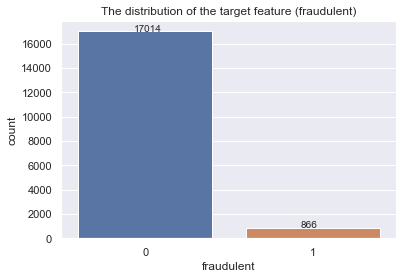

In [69]:
# Let's look at the distribution of the target feature
plt.figure(figsize=(6, 4))
ax = sns.countplot(data.fraudulent)
plt.title('The distribution of the target feature (fraudulent)')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))

plt.show()

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


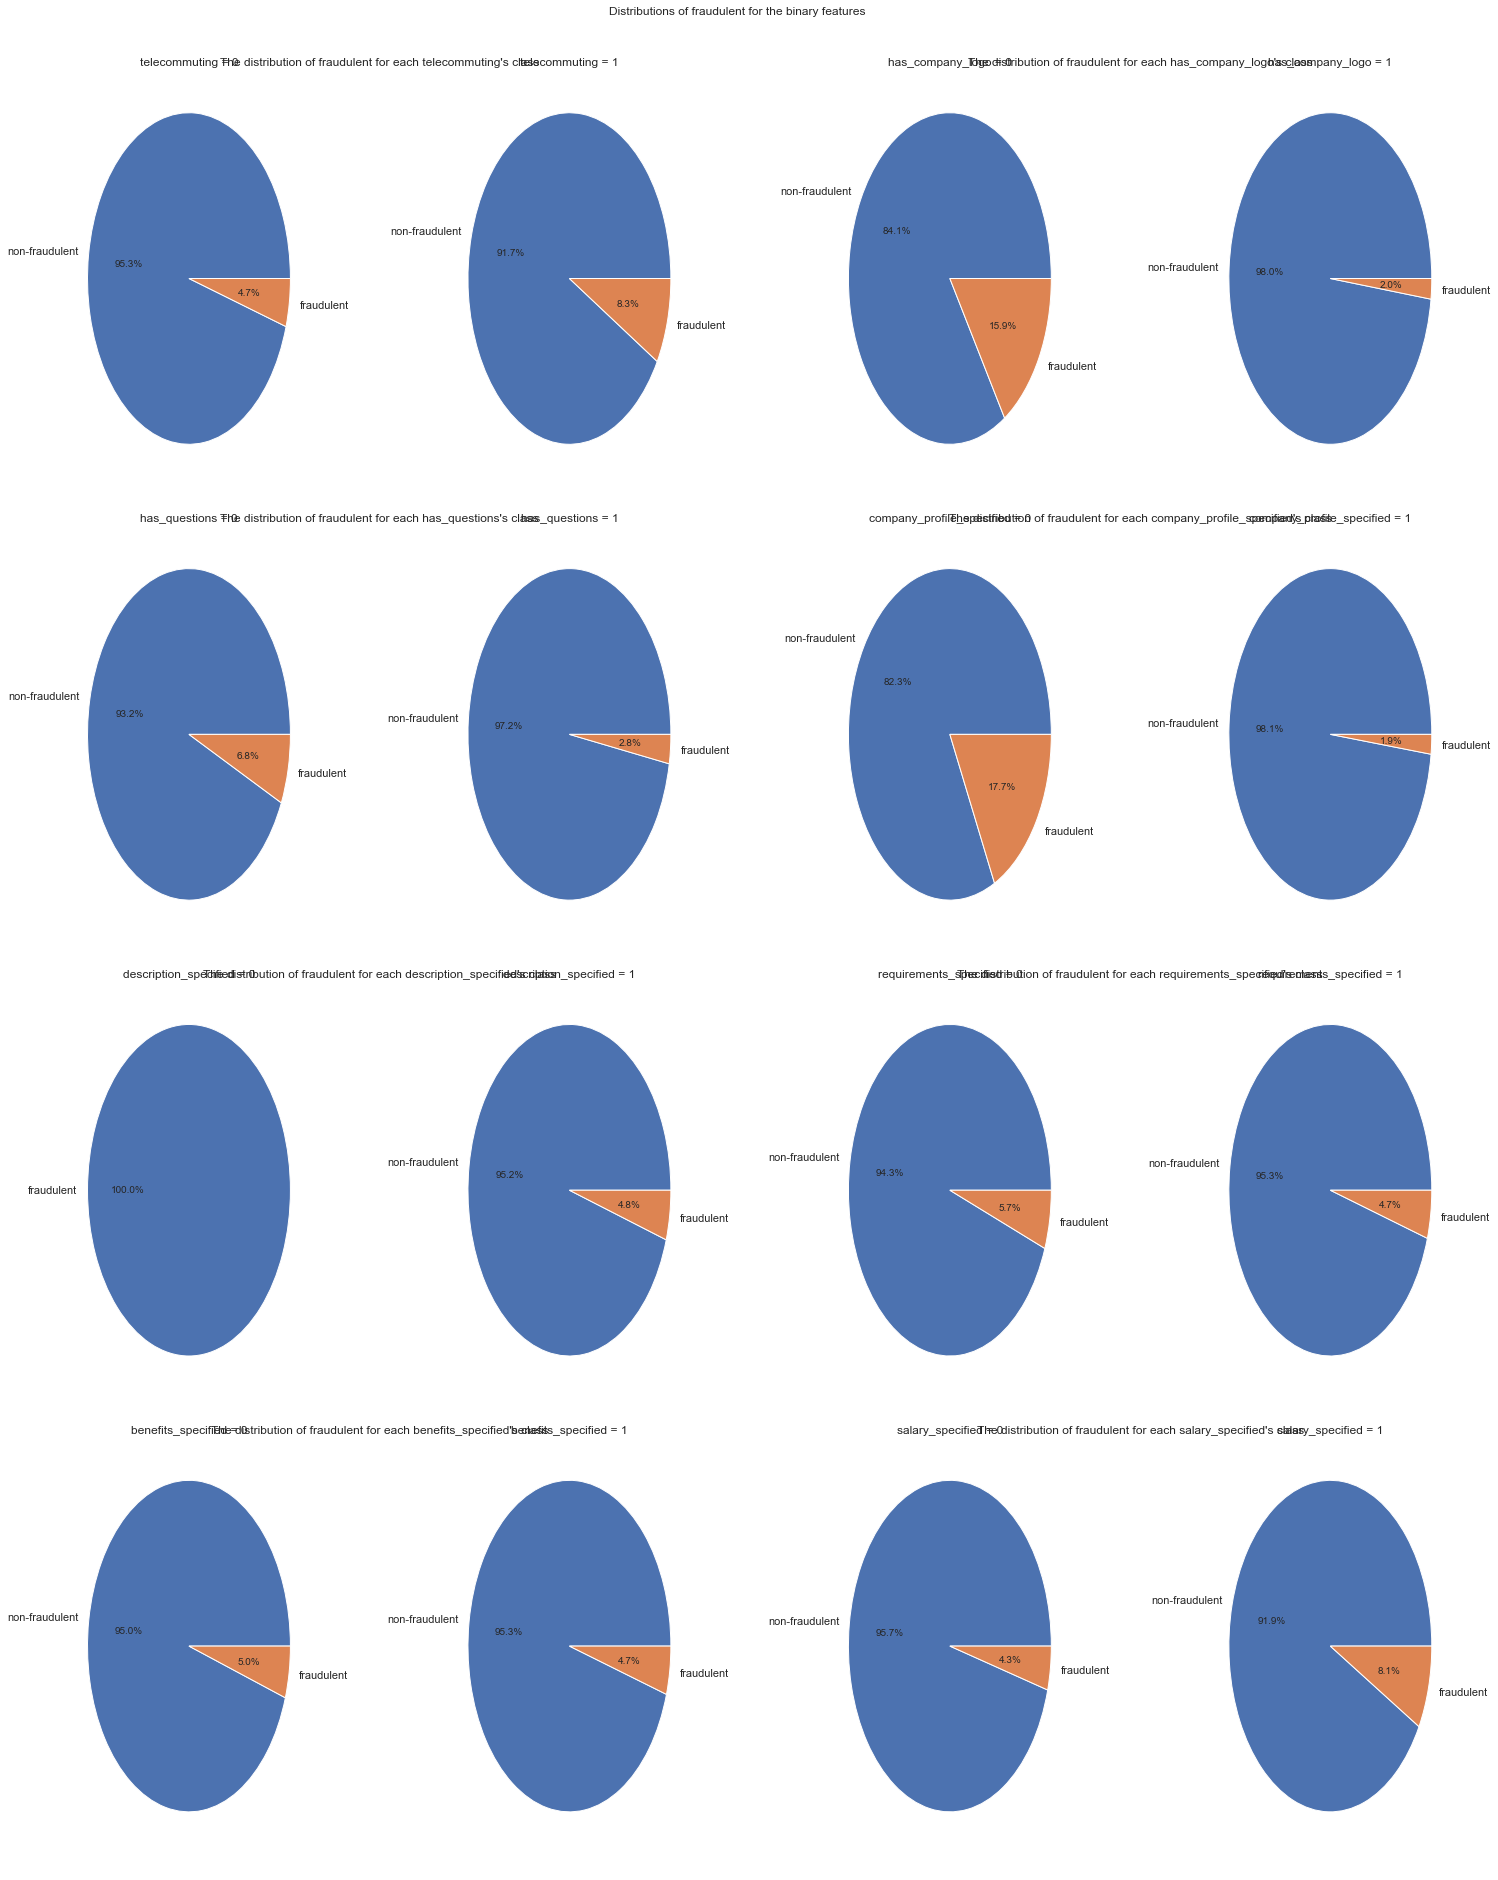

In [70]:
# distributions of fraudulent for the binary features
fig = plt.figure(figsize=(25, 30))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.1)

for feature_ind, feature_name in enumerate(bin_features):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[feature_ind], 
                                             wspace=0.5, hspace=0.7)
    
    ax = plt.Subplot(fig, outer[feature_ind])
    ax.set_title(f'The distribution of fraudulent for each {feature_name}\'s class')
    ax.axis('off')
    fig.add_subplot(ax)
    
    for feature_class in [0, 1]:
        ax = plt.Subplot(fig, inner[feature_class])
        feature_cl_vc = data[data[feature_name] == feature_class].fraudulent.value_counts().sort_index()
        if len(feature_cl_vc) == 2:
            feature_cl_vc.index = ['non-fraudulent', 'fraudulent']
        else:
            feature_cl_vc.index = ['fraudulent']
        
        ax.pie(feature_cl_vc.values, labels=feature_cl_vc.index, autopct='%1.1f%%')
        ax.set_title(f'{feature_name} = {feature_class}')
        fig.add_subplot(ax)

fig.suptitle('Distributions of fraudulent for the binary features')
fig.subplots_adjust(top=0.95)
fig.show()

In [71]:
cont_table = pd.crosstab(data.fraudulent, data.description_specified)
print('Contingency table (fraudulent x description_specified):')
display(cont_table)

Contingency table (fraudulent x description_specified):


description_specified  0      1
fraudulent                     
0                      0  17014
1                      1    865

In [72]:
# Let's check how some of the binary features may be related
def show_feature1_x_feature2_info(feature_name1, feature_name2, figsize=(12, 4), is_binxcat=False):
    '''Shows info about a combination of two binary/categorical features.'''
    cont_table = pd.crosstab(data[feature_name1], data[feature_name2]).fillna(0)
    prop_table = pd.pivot_table(data, index=feature_name1, columns=feature_name2, 
                                values='fraudulent', aggfunc=np.mean).fillna(0)
    
    corr, p = cramers_v(cont_table.values)
    
    if is_binxcat:
        fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    sns.heatmap(cont_table, annot=True, fmt='d', ax=axes[0])
    axes[0].set_title(f'Contingency table:')
    if is_binxcat:
        axes[0].set_xlabel('')
    
    sns.heatmap(prop_table, annot=True, ax=axes[1])
    axes[1].set_title(f'Proportion of fraudulent posts:')
    
    fig_title = f'{feature_name1} x {feature_name2} (Correlation: {round(corr, 4)}, p-value: {round(p, 4)}))'
    if is_binxcat:
        fig.suptitle(fig_title, y=1.05, x=0.45)
    else:
        fig.suptitle(fig_title, y=1.05)
    
    fig.show()

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


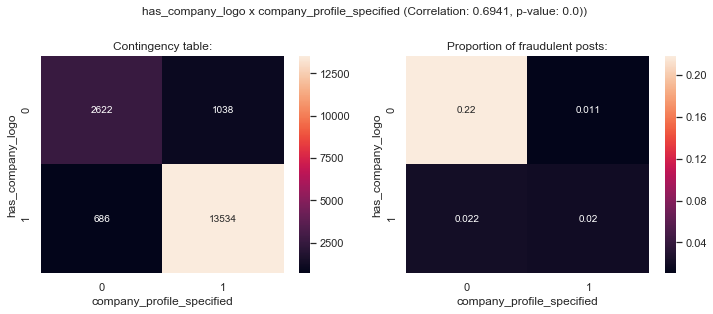

In [73]:
# Here, the largest one of these probabilities of being fraudulent have posts without company's profile and logo, the smallest posts that have them.
show_feature1_x_feature2_info('has_company_logo', 'company_profile_specified')

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


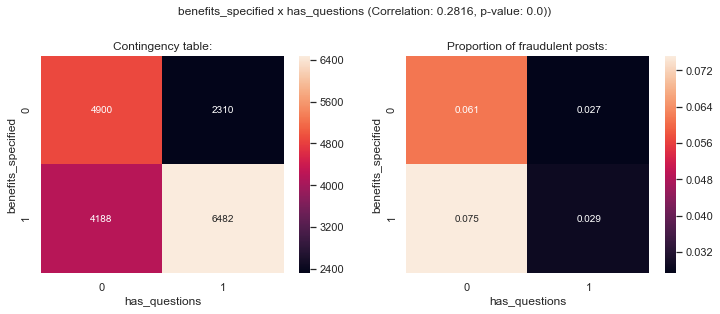

In [74]:
# Here, the largest one of these probabilities of being fraudulent have posts with specified benefits and without announcement of any questions during interview.
show_feature1_x_feature2_info('benefits_specified', 'has_questions')

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


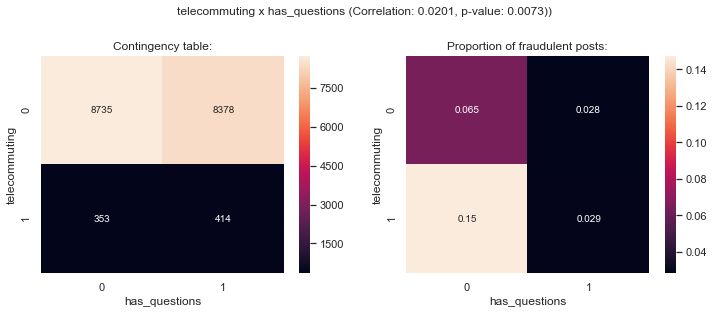

In [75]:
# Here, the largest one of these probabilities of being fraudulent have posts that offer remote work and promise an interview without questions.
show_feature1_x_feature2_info('telecommuting', 'has_questions')

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


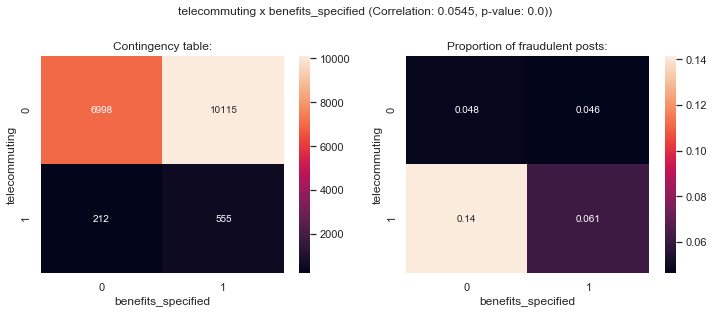

In [76]:
# Here, the largest one of these probabilities of being fraudulent have posts that offer remote work and don't specify any benefits.
show_feature1_x_feature2_info('telecommuting', 'benefits_specified')

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


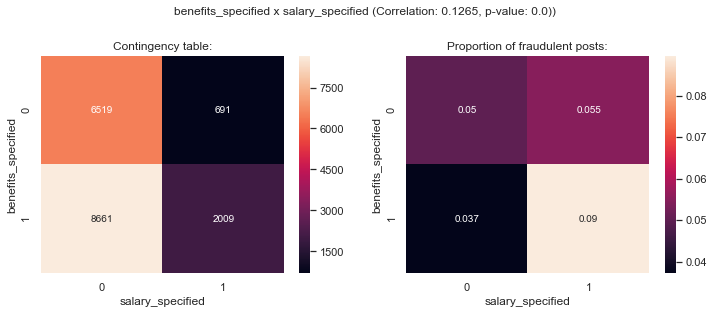

In [77]:
# Here, the largest one of these probabilities of being fraudulent have posts that include specified benefits and specified salaries.
show_feature1_x_feature2_info('benefits_specified', 'salary_specified')

In [78]:
round_confint = lambda confint: list(map(lambda lim: round(lim, 4), confint))

In [79]:
# Let's compare proportions of fraudulent posts for has_questions and salary_specified classes (0 and 1)
def print_stats_for_proportions(feature_name):
    fraudulent_0 = data[data[feature_name] == 0].fraudulent
    fraudulent_1 = data[data[feature_name] == 1].fraudulent
    
    prop_0 = round(np.mean(fraudulent_0), 4)
    prop_1 = round(np.mean(fraudulent_1), 4)
    prop_0_confint = round_confint(proportion_confint(fraudulent_0))
    prop_1_confint = round_confint(proportion_confint(fraudulent_1))
    
    bigger_prop, smaller_prop = (fraudulent_0, fraudulent_1) if prop_0 > prop_1 else (fraudulent_1, fraudulent_0)
    props_diff = round(np.mean(bigger_prop) - np.mean(smaller_prop), 4)
    props_diff_confint = round_confint(proportions_diff_confint_ind(bigger_prop, smaller_prop))
    z_test_p = proportions_ztest_ind(fraudulent_0, fraudulent_1)[1]
    
    print(f'Feature: {feature_name}\n======')
    print(f'Proportion of fraudulent posts for 0: {prop_0}')
    print(f'Proportion of fraudulent posts for 1: {prop_1}')
    print(f'Confidence interval for the proportion of fraudulent posts for 0: {prop_0_confint}')
    print(f'Confidence interval for the proportion of fraudulent posts for 1: {prop_1_confint}')
    print(f'Difference in these proportions: {props_diff}')
    print(f'Confidence interval for the difference in these proportions: {props_diff_confint}')
    print(f'Z-test result: {z_test_p} (p-value)')

In [80]:
print_stats_for_proportions('has_questions')

Feature: has_questions
Proportion of fraudulent posts for 0: 0.0678
Proportion of fraudulent posts for 1: 0.0284
Confidence interval for the proportion of fraudulent posts for 0: [0.0628, 0.0731]
Confidence interval for the proportion of fraudulent posts for 1: [0.0252, 0.0321]
Difference in these proportions: 0.0393
Confidence interval for the difference in these proportions: [0.0331, 0.0456]
Z-test result: 0.0 (p-value)


In [81]:
round((0.0331 / 0.0284) * 100, 1)
# The chance to meet a fraudulent post among posts that don't announce any questions is at least 116.5% higher than the chance to meet it among posts that do it.

116.5

In [82]:
print_stats_for_proportions('salary_specified')

Feature: salary_specified
Proportion of fraudulent posts for 0: 0.0427
Proportion of fraudulent posts for 1: 0.0807
Confidence interval for the proportion of fraudulent posts for 0: [0.0396, 0.046]
Confidence interval for the proportion of fraudulent posts for 1: [0.0711, 0.0916]
Difference in these proportions: 0.0381
Confidence interval for the difference in these proportions: [0.0273, 0.0488]
Z-test result: 0.0 (p-value)


In [83]:
round((0.0273 / 0.0427) * 100, 1)
# When you browse posts with specified salaries it's at least 63.9% higher chance to meet a fraudulent one than when you check posts without specified salaries.

63.9

In [84]:
# Counting the categorical features
for feature_name in cat_features:
    print(f'Count of {feature_name}\'s unique values: {data[feature_name].unique().shape[0]}')

Count of department's unique values: 1338
Count of employment_type's unique values: 6
Count of required_experience's unique values: 8
Count of required_education's unique values: 13
Count of industry's unique values: 132
Count of function's unique values: 38
Count of country's unique values: 91
Count of state's unique values: 325
Count of city's unique values: 2388


In [85]:
# plotting ones that have fewer amount of classes 
def plot_cat_feature_distribution(feature_name):
    '''Makes a plotly chart with categorical feature\'s distribution.'''
    feature_0f = data[data.fraudulent == 0][feature_name].value_counts()
    feature_1f = data[data.fraudulent == 1][feature_name].value_counts()
    
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                        subplot_titles=['non-fraudulent', 'fraudulent'])
    fig.add_trace(go.Pie(labels=feature_0f.index, 
                         values=feature_0f.values), 
                  row=1, col=1)
    fig.add_trace(go.Pie(labels=feature_1f.index, 
                         values=feature_1f.values), 
                  row=1, col=2)
    
    fig.update_layout(title_text=f'The distribution of {feature_name}')
    fig.show()

In [86]:
plot_cat_feature_distribution('employment_type')

In [87]:
plot_cat_feature_distribution('required_experience')

In [88]:
plot_cat_feature_distribution('required_education')

In [89]:
func_meanfr_pt = pd.pivot_table(data, index='function', values='fraudulent', 
                                aggfunc=np.mean).sort_values(by='fraudulent', ascending=False)
func_meanfr_pt.columns = ['Proportion of fraudulent posts']
print('Top-15 function\'s values with the biggest proportions of fraudulent posts:')
display(func_meanfr_pt.head(15))

Top-15 function's values with the biggest proportions of fraudulent posts:


Proportion of fraudulent posts
function                                            
Administrative                              0.188889
Financial Analyst                           0.151515
Accounting/Auditing                         0.136792
Distribution                                0.125000
Other                                       0.098462
Finance                                     0.087209
Engineering                                 0.083828
Business Development                        0.057018
Advertising                                 0.055556
Project Management                          0.054645
Customer Service                            0.054516
Unspecified                                 0.052208
Data Analyst                                0.048780
Human Resources                             0.043902
Sales                                       0.027929

In [90]:
country_meanfr_pt = pd.pivot_table(data, index='country', values='fraudulent', 
                                   aggfunc=np.mean).sort_values(by='fraudulent', ascending=False)
country_meanfr_pt.columns = ['Proportion of fraudulent posts']
print('Top-15 country\'s values with the biggest proportions of fraudulent posts:')
display(country_meanfr_pt.head(15))

Top-15 country's values with the biggest proportions of fraudulent posts:


Proportion of fraudulent posts
country                                   
MY                                0.571429
BH                                0.555556
TW                                0.500000
QA                                0.285714
AU                                0.186916
ID                                0.076923
US                                0.068506
SA                                0.066667
Unpecified                        0.054913
PL                                0.039474
PK                                0.037037
BR                                0.027778
CA                                0.026258
ZA                                0.025000
EG                                0.019231

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



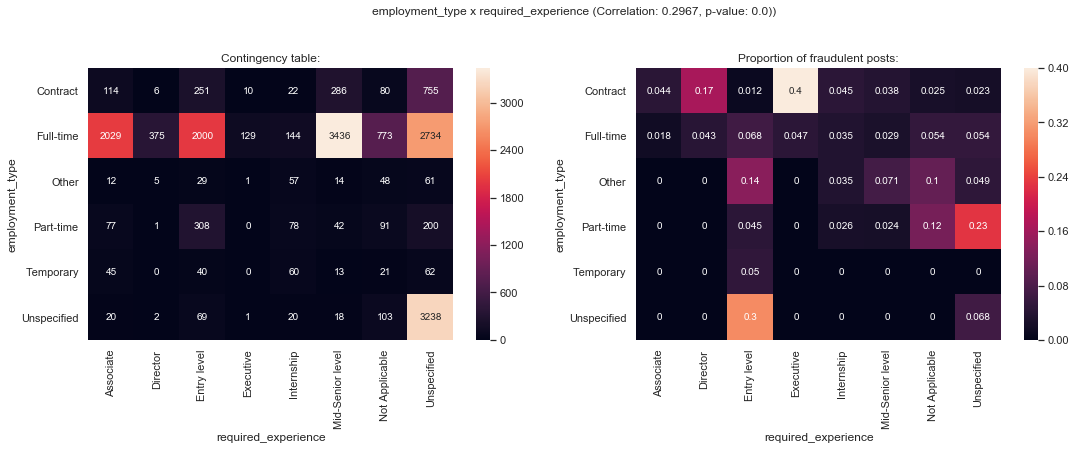

In [91]:
# Let's check how some of categorical and binary features may be related
show_feature1_x_feature2_info('employment_type', 'required_experience', (18, 5))

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



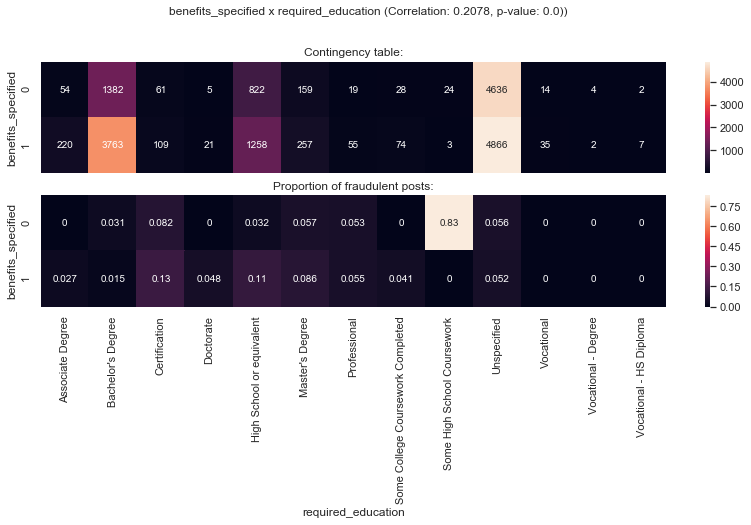

In [92]:
show_feature1_x_feature2_info('benefits_specified', 'required_education', (14, 4.5), True)

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



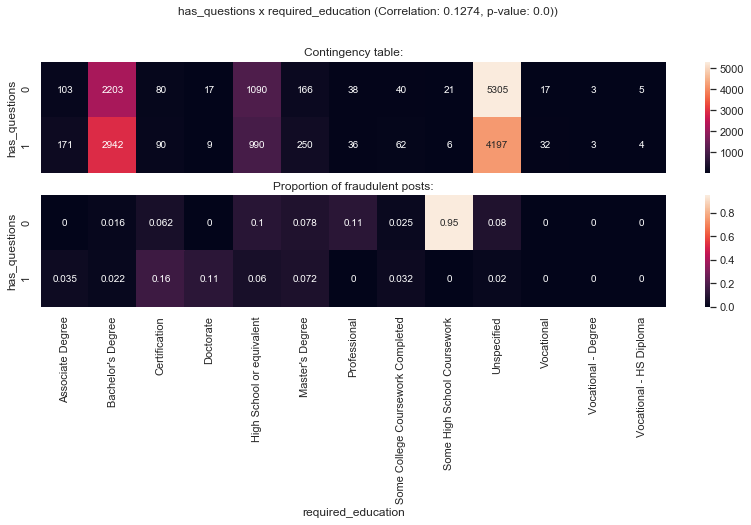

In [93]:
show_feature1_x_feature2_info('has_questions', 'required_education', (14, 4.5), True)

/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



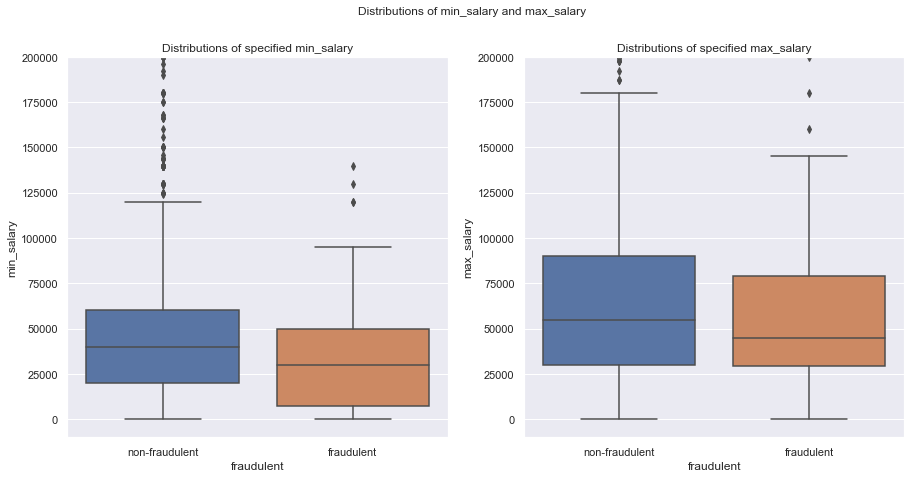

In [94]:
# Now let's look at the numerical features (salary info)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for ind, feature_name in enumerate(num_features):
    sns.boxplot(y=feature_name, x='fraudulent', data=data[data.salary_specified == 1], ax=axes[ind])
    axes[ind].set_ylim([-1e4, 2e5])
    axes[ind].set_xticklabels(['non-fraudulent', 'fraudulent'])
    axes[ind].set_title(f'Distributions of specified {feature_name}')

fig.suptitle('Distributions of min_salary and max_salary')
fig.show()

In [95]:
# Let's look at differencies between min and max salaries
diff_salary = data[data.salary_specified == 1]['max_salary'] - data[data.salary_specified == 1]['min_salary']

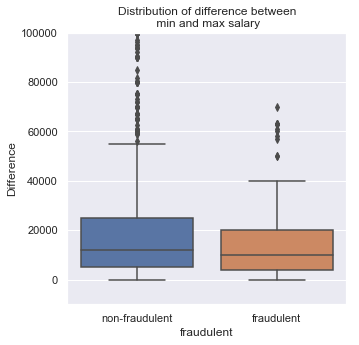

In [96]:
plt.figure(figsize=(5, 5))
sns.boxplot(y=diff_salary, x='fraudulent', data=data[data.salary_specified == 1])
plt.ylim([-1e4, 1e5])
plt.xticks([0, 1], ['non-fraudulent', 'fraudulent'])
plt.ylabel('Difference')
plt.title('Distribution of difference between\n min and max salary')
plt.show()

In [97]:
# There is a difference in medians, let's calculate them and some descriptive statistics there is no sense in compairing means because there are too many outliers here)
specified_salaries = data[data.salary_specified == 1][num_features]
specified_salaries['difference'] = diff_salary
specified_salaries['fraudulent'] = data.fraudulent
specified_salaries.head()

min_salary  max_salary  difference  fraudulent
6        20000       28000        8000           0
10      100000      120000       20000           0
15      120000      150000       30000           0
23      100000      120000       20000           0
31       50000       65000       15000           0

In [98]:
np.sum(np.unique(specified_salaries.min_salary, return_counts=True)[1] > 10)
# We can't use Mann–Whitney U test for distributions comparison because of this 

48

In [99]:
np.sum(np.unique(specified_salaries.max_salary, return_counts=True)[1] > 10)

47

In [100]:
# so we will use Permutation test
def print_stats_for_salary(feature_name):
    '''Calculates statistics for fraudulent and non-fraudulent salary-feature.'''
    np.random.seed(42)
    feature_0f = specified_salaries[specified_salaries.fraudulent == 0][feature_name]
    feature_1f = specified_salaries[specified_salaries.fraudulent == 1][feature_name]
    
    med_0f = np.median(feature_0f)
    med_1f = np.median(feature_1f)
    med_0f_confint = bootstrap_statint(feature_0f.values, stat=np.median)
    med_1f_confint = bootstrap_statint(feature_1f.values, stat=np.median)
    
    bigger_med, smaller_med = (feature_0f, feature_1f) if med_0f > med_1f else (feature_1f, feature_0f)
    med_diff = np.median(bigger_med) - np.median(smaller_med)
    med_diff_confint = bootstrap_statint_diff(bigger_med.values, smaller_med.values, stat=np.median)
    perm_test_p = permutation_test_ind(feature_0f, feature_1f, max_permutations=5000)[1]
    
    print(f'Feature: {feature_name}\n======')
    print(f'Median of {feature_name} in non-fraudulent posts: {med_0f}')
    print(f'Median of {feature_name} in fraudulent posts:     {med_1f}')
    print(f'Statistical interval for the median of {feature_name} in non-fraudulent posts: {med_0f_confint}')
    print(f'Statistical interval for the median of {feature_name} in fraudulent posts:     {med_1f_confint}')
    print(f'Difference in these medians: {med_diff}')
    print(f'Statistical interval for the difference in these medians: {med_diff_confint}')
    print(f'Permutation test result: {perm_test_p} (p-value)')

In [101]:
print_stats_for_salary('min_salary')

Feature: min_salary
Median of min_salary in non-fraudulent posts: 40000.0
Median of min_salary in fraudulent posts:     30000.0
Statistical interval for the median of min_salary in non-fraudulent posts: [39000. 40000.]
Statistical interval for the median of min_salary in fraudulent posts:     [27000. 30000.]
Difference in these medians: 10000.0
Statistical interval for the difference in these medians: [ 9000. 13000.]
Permutation test result: 0.8066 (p-value)


In [102]:
print_stats_for_salary('max_salary')

Feature: max_salary
Median of max_salary in non-fraudulent posts: 55000.0
Median of max_salary in fraudulent posts:     45000.0
Statistical interval for the median of max_salary in non-fraudulent posts: [50000. 58000.]
Statistical interval for the median of max_salary in fraudulent posts:     [40000. 50000.]
Difference in these medians: 10000.0
Statistical interval for the difference in these medians: [    0. 15000.]
Permutation test result: 0.8924 (p-value)


In [103]:
print_stats_for_salary('difference')
# Here the differences between min_salary's medians of 0 and 1 fraudulent groups are much more significant than between max_salary's and different's ones. But there isn't difference in distributions for any of them.

Feature: difference
Median of difference in non-fraudulent posts: 12000.0
Median of difference in fraudulent posts:     10000.0
Statistical interval for the median of difference in non-fraudulent posts: [10000. 15000.]
Statistical interval for the median of difference in fraudulent posts:     [ 8000. 10000.]
Difference in these medians: 2000.0
Statistical interval for the difference in these medians: [   0. 5000.]
Permutation test result: 0.853 (p-value)


/Users/vamsiraju/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



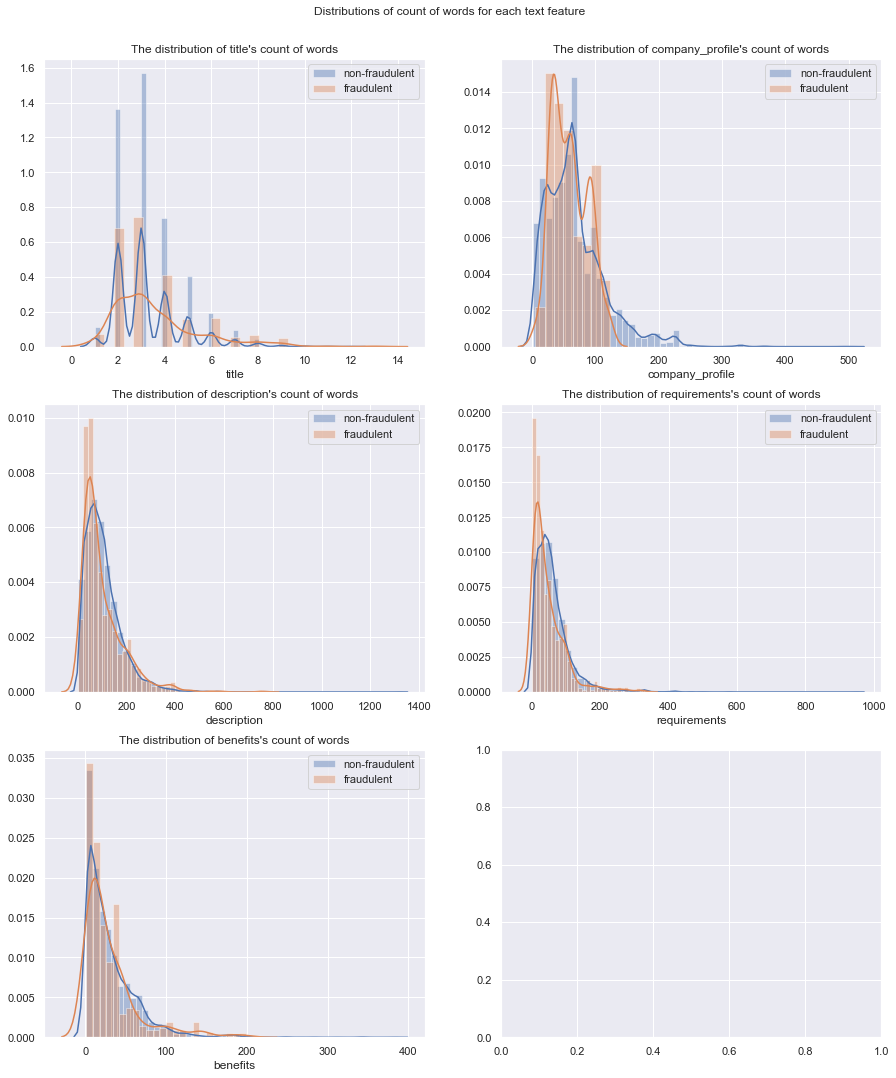

In [104]:
# Comparing mean count of words and distributions of lenghts of each textual feature for groups of 0 and 1 fraudulent
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

text_features_gen = iter(text_features)

for row in range(3):
    for col in range(2):
        try:
            feature_name = next(text_features_gen)
        except StopIteration:
            break
        
        if feature_name == 'title':
            feature_values_0f = data[(data.fraudulent == 0)][feature_name].astype(str)
            feature_values_1f = data[(data.fraudulent == 1)][feature_name].astype(str)
        else:
            feature_values_0f = data[(data.fraudulent == 0) & data[f'{feature_name}_specified']][feature_name].astype(str)
            feature_values_1f = data[(data.fraudulent == 1) & data[f'{feature_name}_specified']][feature_name].astype(str)

        fv_0f_len = feature_values_0f.str.split(' ').apply(len)
        fv_1f_len = feature_values_1f.str.split(' ').apply(len)
        
        sns.distplot(fv_0f_len, label='non-fraudulent', ax=axes[row, col])
        sns.distplot(fv_1f_len, label='fraudulent', ax=axes[row, col])
        axes[row, col].set_title(f'The distribution of {feature_name}\'s count of words')
        axes[row, col].legend()
        
fig.suptitle('Distributions of count of words for each text feature', y=0.92)
fig.show()

In [105]:
def print_stats_for_texts(feature_name):
    '''Calculates statistics for fraudulent and non-fraudulent count of words in feature\'s texts.'''
    if feature_name == 'title':
        feature_values_0f = data[(data.fraudulent == 0)][feature_name].astype(str)
        feature_values_1f = data[(data.fraudulent == 1)][feature_name].astype(str)
    else:
        feature_values_0f = data[(data.fraudulent == 0) & data[f'{feature_name}_specified']][feature_name].astype(str)
        feature_values_1f = data[(data.fraudulent == 1) & data[f'{feature_name}_specified']][feature_name].astype(str)
    
    lens_0f = feature_values_0f.str.split(' ').apply(len)
    lens_1f = feature_values_1f.str.split(' ').apply(len)
    
    mean_lens_0f = round(np.mean(lens_0f), 4)
    mean_lens_1f = round(np.mean(lens_1f), 4)
    mean_lens_0f_confint = round_confint(tconfint(lens_0f.values))
    mean_lens_1f_confint = round_confint(tconfint(lens_1f.values))
    
    bigger_mean, smaller_mean = (lens_0f, lens_1f) if mean_lens_0f > mean_lens_1f else (lens_1f, lens_0f)
    mean_diff = round(np.mean(bigger_mean) - np.mean(smaller_mean), 4)
    
    mean_diff_confint = round_confint(tconfint_diff(bigger_mean.values, smaller_mean.values))
    perm_test_p = permutation_test_ind(lens_0f, lens_1f, max_permutations=5000)[1]
    
    print(f'Feature: {feature_name}\n======')
    print(f'Mean of {feature_name}\'s count of words in non-fraudulent posts: {mean_lens_0f}')
    print(f'Mean of {feature_name}\'s count of words in fraudulent posts:     {mean_lens_1f}')
    print(f'Confidence interval for the mean of {feature_name}\'s count of words in non-fraudulent posts: {mean_lens_0f_confint}')
    print(f'Confidence interval for the mean of {feature_name}\'s count of words in fraudulent posts:     {mean_lens_1f_confint}')
    print(f'Difference in these means: {mean_diff}')
    print(f'Confidence interval for the difference in these means: {mean_diff_confint}')
    print(f'Permutation test result: {perm_test_p} (p-value)')

In [106]:
for feature_name in text_features:
    print_stats_for_texts(feature_name)
    print()

Feature: title
Mean of title's count of words in non-fraudulent posts: 3.2794
Mean of title's count of words in fraudulent posts:     3.5612
Confidence interval for the mean of title's count of words in non-fraudulent posts: [3.258, 3.3007]
Confidence interval for the mean of title's count of words in fraudulent posts:     [3.4392, 3.6832]
Difference in these means: 0.2818
Confidence interval for the difference in these means: [0.158, 0.4057]
Permutation test result: 0.0002 (p-value)

Feature: company_profile
Mean of company_profile's count of words in non-fraudulent posts: 66.9309
Mean of company_profile's count of words in fraudulent posts:     59.2294
Confidence interval for the mean of company_profile's count of words in non-fraudulent posts: [66.1698, 67.692]
Confidence interval for the mean of company_profile's count of words in fraudulent posts:     [55.9672, 62.4916]
Difference in these means: 7.7015
Confidence interval for the difference in these means: [4.3524, 11.0505]
Permu

In [107]:
# Let's create two new numerical features for company_profile's and requirements's count of words
data['company_profile_count_of_words'] = data['company_profile'].astype(str).str.split(' ').apply(len)
data['requirements_count_of_words'] = data['requirements'].astype(str).str.split(' ').apply(len)
data.head()[['company_profile_count_of_words', 'requirements_count_of_words']]

company_profile_count_of_words  requirements_count_of_words
0                              86                           73
1                              96                          117
2                              75                          103
3                              55                          121
4                             146                           61

In [108]:
num_features += ['company_profile_count_of_words', 'requirements_count_of_words']

In [109]:
# Let's increase the count of 1 fraudulent records in the dataset using oversampling
data_1f = data[data.fraudulent == 1]

In [110]:
original_data = data.copy()
data = pd.concat([data] + [data_1f] * 7, axis=0)

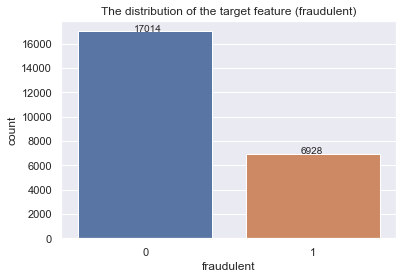

In [111]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data.fraudulent)
plt.title('The distribution of the target feature (fraudulent)')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))

plt.show()

In [112]:
# Cross-validation splitter
skf = StratifiedKFold(n_splits=4, random_state=42)

In [113]:
# Dividing features and targets
X, y = data.drop('fraudulent', axis=1), data.fraudulent

In [114]:
# Numerical features have to be scaled, categorical features have to be transformed into sets of binary ones and text features have to be vectorized (I'm using TF-IDF method)
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
text_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2)))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        *[(feature_name, text_transformer, feature_name) 
          for feature_name in text_features]
    ]
)

In [115]:
# Logistic regression model
log_reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression())])

In [116]:
%%time
cv_scores = cross_validate(log_reg_pipe, X, y, return_train_score=True, cv=skf, 
                           scoring=['accuracy', 'roc_auc'], n_jobs=-1)

print(f'Accuracy on train part: {cv_scores["train_accuracy"]}, mean: {cv_scores["train_accuracy"].mean()}')
print(f'Accuracy on test part:  {cv_scores["test_accuracy"]}, mean: {cv_scores["test_accuracy"].mean()}')
print(f'ROC AUC on train part: {cv_scores["train_roc_auc"]}, mean: {cv_scores["train_roc_auc"].mean()}')
print(f'ROC AUC on test part:  {cv_scores["test_roc_auc"]}, mean: {cv_scores["test_roc_auc"].mean()}')

Accuracy on train part: [0.99955447 0.99949877 0.99944311 0.99955449], mean: 0.999512711661765
Accuracy on test part:  [0.99031073 0.98897427 0.99565581 0.99298246], mean: 0.9919808151629771
ROC AUC on train part: [0.99996805 0.99999149 0.99996806 0.99996996], mean: 0.9999743907255456
ROC AUC on test part:  [0.99920032 0.99854423 0.99986397 0.99934512], mean: 0.9992384097043099
CPU times: user 505 ms, sys: 285 ms, total: 790 ms
Wall time: 2min 56s


In [117]:
feature_names = num_features.copy()

num_features_scaled = StandardScaler().fit_transform(data[num_features])
X = num_features_scaled

feature_names += bin_features
X = np.hstack([X, data[bin_features]])


for feature_name in cat_features:
    encoder = OneHotEncoder()
    encoded_feature = encoder.fit_transform(data[feature_name].values.reshape(-1, 1))
    
    X = sparse_hstack([X, encoded_feature])
    f_names = list(map(lambda cat: f'{feature_name}:{cat}', encoder.categories_[0]))
    feature_names += f_names

for feature_name in text_features:
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    vectorized_feature = vectorizer.fit_transform(data[feature_name])
    
    X = sparse_hstack([X, vectorized_feature])
    sorted_phrases = [pair[0] for pair in list(sorted(vectorizer.vocabulary_.items(), 
                                                      key=lambda pair: pair[1]))]
    f_names = list(map(lambda phrase: f'{feature_name}:{phrase}', sorted_phrases))
    feature_names += f_names

In [118]:
X.shape[1], len(feature_names)

(1273071, 1273071)

In [121]:
!pip install eli5 

You should consider upgrading via the '/Users/vamsiraju/anaconda3/bin/python -m pip install --upgrade pip' command.


In [123]:
import eli5

Using TensorFlow backend.


In [122]:
!brew install libomp

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
rustscan                   vivid                      webify
==> Updated Formulae
Updated 419 formulae.
==> Renamed Formulae
gst-validate -> gst-devtools
xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun

To reinstall 10.0.1, run `brew reinstall libomp`


In [119]:
log_reg = LogisticRegression(random_state=42, n_jobs=-1).fit(X, y)

In [124]:
eli5.explain_weights(log_reg, feature_names=feature_names, top=(30, 30))

Explanation(estimator='LogisticRegression(n_jobs=-1, random_state=42)', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='department:Information Technology ', weight=2.5567348785928634, std=None, value=None), FeatureWeight(feature='industry:Oil & Energy', weight=2.5528878470529266, std=None, value=None), FeatureWeight(feature='country:MY', weight=2.3716465195145284, std=None, value=None), FeatureWeight(feature='benefits:salaryk', weight=2.2770288949639483, std=None, value=None), FeatureWeight(feature='title:administr', weight=2.2711140519406166, std=None, value=None), FeatureWeight(feature='title:custom assist', weight=2.248022517531905, std=None, value=None), FeatureWeight(feature='city:AUSTIN', weight=2.243113029174519, std=None, value=None), FeatureWeight(feature='city:San Mateo', weight=2.226498741978669, std=None, value=None), FeatureWeight(feature='title:posit', weight=2.163283439786555, std=None, value=None), FeatureWeight(feature='industry:Accounting', weight=2.1080859109058383, std=None, value=None), FeatureWeight(feature='company_profile:accion', weight=2.0194023845028264, std=None, value=None), FeatureWeight(feature='department:Oil & Energy', weight=1.8791207081511572, std=None, value=None), FeatureWeight(feature='company_profile:bonu', weight=1.734221411979388, std=None, value=None), FeatureWeight(feature='country:Unpecified', weight=1.7329163044251688, std=None, value=None), FeatureWeight(feature='title:home', weight=1.7243240757553933, std=None, value=None), FeatureWeight(feature='industry:Hospitality', weight=1.6332416331767536, std=None, value=None), FeatureWeight(feature='city:london', weight=1.5662231075007418, std=None, value=None), FeatureWeight(feature='city:DALLAS', weight=1.550002339682214, std=None, value=None), FeatureWeight(feature='title:csr', weight=1.5396742822691107, std=None, value=None), FeatureWeight(feature='title:center', weight=1.4938688813988001, std=None, value=None), FeatureWeight(feature='city:Groveport', weight=1.4758051783194148, std=None, value=None), FeatureWeight(feature='city:Bakersfield', weight=1.4732049816452566, std=None, value=None), FeatureWeight(feature='country:AU', weight=1.4697272488268671, std=None, value=None), FeatureWeight(feature='description:earn', weight=1.4681558097437946, std=None, value=None), FeatureWeight(feature='company_profile:aptitud staf', weight=1.4401356697043814, std=None, value=None), FeatureWeight(feature='industry:Hospital & Health Care', weight=1.4281860178738879, std=None, value=None), FeatureWeight(feature='company_profile:aptitud', weight=1.4236057070291819, std=None, value=None), FeatureWeight(feature='city:Bellevue', weight=1.4223414653815936, std=None, value=None), FeatureWeight(feature='title:work', weight=1.4205294641737527, std=None, value=None), FeatureWeight(feature='city:chicago', weight=1.4178849564816858, std=None, value=None)], neg=[FeatureWeight(feature='industry:Restaurants', weight=-2.021770667742795, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=-1.9314874171758818, std=None, value=None), FeatureWeight(feature='industry:Internet', weight=-1.8612937354400685, std=None, value=None), FeatureWeight(feature='function:Health Care Provider', weight=-1.8203570229834685, std=None, value=None), FeatureWeight(feature='has_company_logo', weight=-1.6318043109358518, std=None, value=None), FeatureWeight(feature='industry:Compute

In [125]:
#The country value with the biggest positive weight is MY, which is top-1 country in "Proportion of fraudulent posts" table(for the country feature, value of proportion - 0.571429). The country with the smallest count of fraudulent posts is GR
original_data[original_data.country == 'MY'].fraudulent.value_counts().sort_index()

0     9
1    12
Name: fraudulent, dtype: int64

In [126]:
original_data[original_data.country == 'GR'].fraudulent.value_counts().sort_index()

0    940
Name: fraudulent, dtype: int64

In [127]:
original_data[original_data.industry == 'Accounting'].fraudulent.value_counts().sort_index()

0    102
1     57
Name: fraudulent, dtype: int64

In [128]:
original_data[original_data.industry == 'Internet'].fraudulent.value_counts().sort_index()

0    1062
Name: fraudulent, dtype: int64

In [129]:
original_data[original_data.city == 'london'].fraudulent.value_counts().sort_index()

0    11
1     3
Name: fraudulent, dtype: int64

In [130]:
original_data[original_data.city == 'London'].fraudulent.value_counts().sort_index()

0    1056
1       4
Name: fraudulent, dtype: int64

In [131]:
original_data[original_data.city == 'chicago'].fraudulent.value_counts().sort_index()

0    8
1    4
Name: fraudulent, dtype: int64

In [132]:
original_data[original_data.city == 'Chicago'].fraudulent.value_counts().sort_index()

0    253
1      4
Name: fraudulent, dtype: int64

In [138]:
#We can also conclude that fraudulent post writers often start writing London (and many other city names) using the lowercase letter